Proyecto final del optativo PROCESAMIENTO DE IMÁGENES

Integrantes:
    Kevin Talavera Díaz C-311
    Raul Beltrán Gómez C-312
    Emmanuel Torres González C-312

Un QuadTree es un árbol en el que cada nodo tiene 4 hijos excepto los nodos hoja.
Son muy usados a la hora de subdividir espacios 2D recursivamente en 4 cuadrantes.

En este proyecto aplicaremos la estructura de datos mencionada anteriormente de la siguiente forma:

En la primera iteración del algoritmo la imagen se subdivide en 4 nodos, para los cuales se calcula el color medio de su nodo (El promedio del RGB de todos los píxeles del nodo) y ese será el color con el que se muestre dicho cuadrante, a esta iteración nos referimos como imagen de nivel 1.
En la siguiente iteración cada uno de los cuadrantes se subdivide en 4 y esos nodos pasan a ser hijos del nodo subdividido en el árbol, luego se calculan las medias de colores por cada una de esas subdivisiones y si alguna coincide en color estas se mezclan y pasan a ser el mismo nodo, y este vendría siendo el nivel 2.
Por lo que después de k iteraciones tendremos un árbol de nivel k en el cual mientras más alto sea el valor de dicho k, mejor se verá la imagen.
En nuestro algoritmo podemos obtener el nivel del árbol que deseemos en dependencia de la situación, si necesitamos más o menos calidad.







In [69]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from PIL import Image
from matplotlib.pyplot import gray
from numpy import array

img = mpimg.imread('image.jpg')
img.shape

(267, 250, 3)

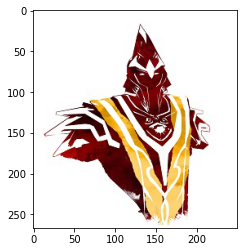

In [70]:
plt.imshow(img)

Aquí vemos la subdivisión de nivel 1 de la imagen, pero aún sin hacer el cálculo de la media de los colores

In [71]:
from operator import add
from functools import reduce

def split4(image):
    half_split = np.array_split(image, 2)
    res = map(lambda x: np.array_split(x, 2, axis=1), half_split)
    return reduce(add, res)

split_img = split4(img)
split_img[0].shape

(134, 125, 3)

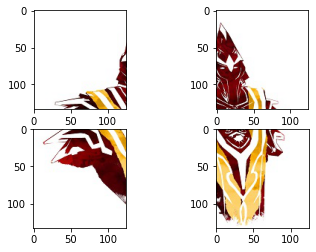

In [72]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(split_img[0])
axs[0, 1].imshow(split_img[1])
axs[1, 0].imshow(split_img[2])
axs[1, 1].imshow(split_img[3])

Aquí se calculan las medias de colores a cada subdivisión, y se muestran

[[[241 235 231]
  [223 205 203]]

 [[216 194 189]
  [226 203 180]]]


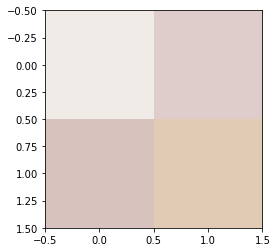

In [73]:
def calculate_mean(img):
    return np.mean(img, axis=(0, 1))

means = np.array(list(map(lambda x: calculate_mean(x), split_img))).astype(int).reshape(2,2,3)
print(means)
plt.imshow(means)
plt.show()

In [74]:
def checkEqual(myList):
    first=myList[0]
    return all((x==first).all() for x in myList)

def concatenate4(north_west, north_east, south_west, south_east):
    top = np.concatenate((north_west, north_east), axis=1)
    bottom = np.concatenate((south_west, south_east), axis=1)
    return np.concatenate((top, bottom), axis=0)

class QuadTree:
    
    def insert(self, img, level = 0):
        self.level = level
        self.mean = calculate_mean(img).astype(int)
        self.resolution = (img.shape[0], img.shape[1])
        self.final = True
        
        if not checkEqual(img):
            split_img = split4(img)
            
            self.final = False
            self.north_west = QuadTree().insert(split_img[0], level + 1)
            self.north_east = QuadTree().insert(split_img[1], level + 1)
            self.south_west = QuadTree().insert(split_img[2], level + 1)
            self.south_east = QuadTree().insert(split_img[3], level + 1)

        return self
    
    def get_image(self, level):
        if(self.final or self.level == level):
            return np.tile(self.mean, (self.resolution[0], self.resolution[1], 1))
        
        return concatenate4(
            self.north_west.get_image(level), 
            self.north_east.get_image(level),
            self.south_west.get_image(level),
            self.south_east.get_image(level))
    
    def get_border(self, level):
        if(self.final or self.level == level):
            return cv2.copyMakeBorder((
            np.tile(self.mean, (self.resolution[0], self.resolution[1], 1))[1:self.resolution[0]-1,1:self.resolution[1]-1]),
            1, 1, 1, 1, cv2.BORDER_CONSTANT, value=[0, 0, 255])
        
        return concatenate4(
            self.north_west.get_border(level), 
            self.north_east.get_border(level),
            self.south_west.get_border(level),
            self.south_east.get_border(level))
    
    def get_cluster(self, level):
        cluster = np.zeros((self.resolution[0], self.resolution[1]))
        img = self.get_image(level)
        for i in range(self.resolution[0]):
            for j in range(self.resolution[1]):
                if(len(img[i][j]) == 3):
                    cluster[i, j] = (img[i][j][0] + img[i][j][1] + img[i][j][2]) / 765
                else:
                    cluster[i, j] = (img[i][j][0]) / 255
        return cluster

Aquí es donde se crea el quadtree que le corresponde a la imagen y se van mostrando las imágenes correspondientes a diferentes niveles del árbol

In [75]:
quadtree = QuadTree().insert(img)

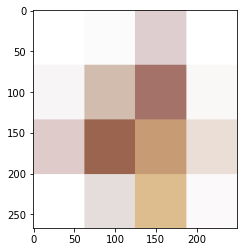

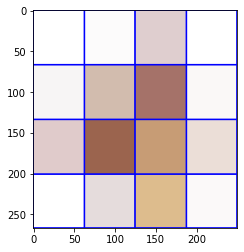

In [76]:
plt.imshow(quadtree.get_image(2))
plt.show()
plt.imshow(quadtree.get_border(2))
plt.show()

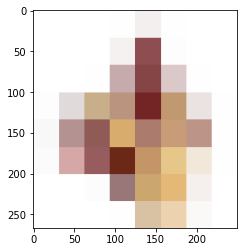

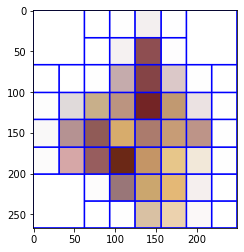

In [77]:
plt.imshow(quadtree.get_image(3))
plt.show()
plt.imshow(quadtree.get_border(3))
plt.show()

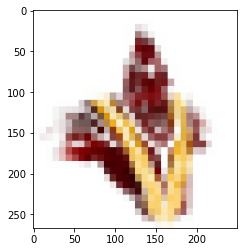

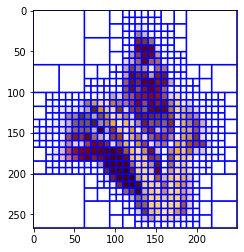

In [78]:
plt.imshow(quadtree.get_image(5))
plt.show()
plt.imshow(quadtree.get_border(5))
plt.show()

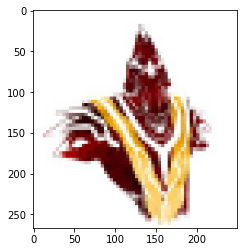

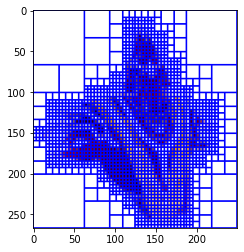

In [79]:
plt.imshow(quadtree.get_image(6))
plt.show()
plt.imshow(quadtree.get_border(6))
plt.show()

CLUSTERS

In [80]:
cluster = quadtree.get_cluster(1)
print(cluster)

[[0.92418301 0.92418301 0.92418301 ... 0.8248366  0.8248366  0.8248366 ]
 [0.92418301 0.92418301 0.92418301 ... 0.8248366  0.8248366  0.8248366 ]
 [0.92418301 0.92418301 0.92418301 ... 0.8248366  0.8248366  0.8248366 ]
 ...
 [0.78300654 0.78300654 0.78300654 ... 0.79607843 0.79607843 0.79607843]
 [0.78300654 0.78300654 0.78300654 ... 0.79607843 0.79607843 0.79607843]
 [0.78300654 0.78300654 0.78300654 ... 0.79607843 0.79607843 0.79607843]]


In [81]:
cluster = quadtree.get_cluster(2)
print(cluster)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.97908497 0.97908497 0.97908497]
 [1.         1.         1.         ... 0.97908497 0.97908497 0.97908497]
 [1.         1.         1.         ... 0.97908497 0.97908497 0.97908497]]


Foto de un solo color


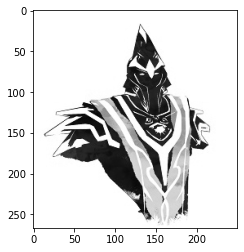

In [82]:
gray()
img_gray = array(Image.open('image.jpg').convert('L'), dtype='float64')

quadtree = QuadTree().insert(img_gray)

plt.imshow(img_gray)

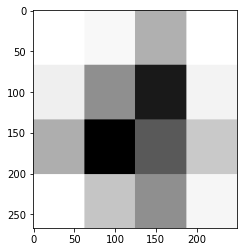

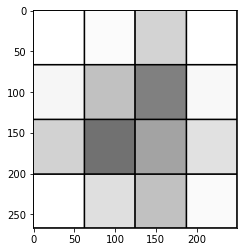

In [83]:
plt.imshow(quadtree.get_image(2))
plt.show()
plt.imshow(quadtree.get_border(2))
plt.show()

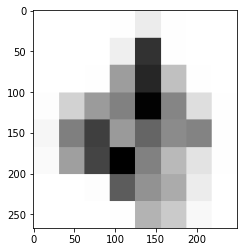

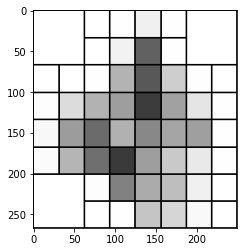

In [84]:
plt.imshow(quadtree.get_image(3))
plt.show()
plt.imshow(quadtree.get_border(3))
plt.show()

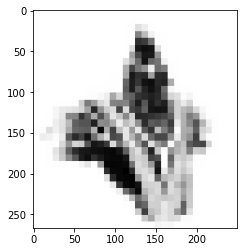

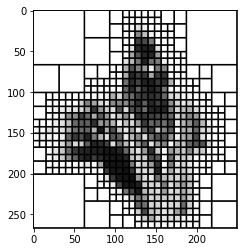

In [85]:
plt.imshow(quadtree.get_image(5))
plt.show()
plt.imshow(quadtree.get_border(5))
plt.show()

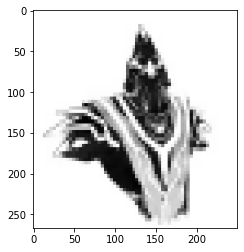

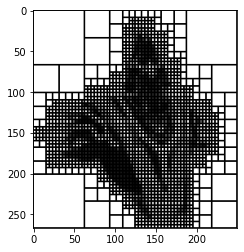

In [86]:
plt.imshow(quadtree.get_image(6))
plt.show()
plt.imshow(quadtree.get_border(6))
plt.show()

In [87]:
cluster = quadtree.get_cluster(1)
print(cluster)

[[0.9254902  0.9254902  0.9254902  ... 0.82352941 0.82352941 0.82352941]
 [0.9254902  0.9254902  0.9254902  ... 0.82352941 0.82352941 0.82352941]
 [0.9254902  0.9254902  0.9254902  ... 0.82352941 0.82352941 0.82352941]
 ...
 [0.78431373 0.78431373 0.78431373 ... 0.81568627 0.81568627 0.81568627]
 [0.78431373 0.78431373 0.78431373 ... 0.81568627 0.81568627 0.81568627]
 [0.78431373 0.78431373 0.78431373 ... 0.81568627 0.81568627 0.81568627]]


In [88]:
cluster = quadtree.get_cluster(2)
print(cluster)

[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 0.98039216 0.98039216 0.98039216]
 [1.         1.         1.         ... 0.98039216 0.98039216 0.98039216]
 [1.         1.         1.         ... 0.98039216 0.98039216 0.98039216]]
